# Deep Autoencoding Gaussian Mixture Model for Unsupervised Anomaly Detection

In [6]:
import numpy as np 
import pandas as pd
import torch
from data_loader import *
from main import *
from tqdm import tqdm

## KDD Cup 1999 Data (10% subset)
This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between "bad" connections, called intrusions or attacks, and "good" normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment. 

In [ ]:
data = pd.read_csv("kddcup.data_10_percent_corrected", header=None,names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'type'])

### Pre-processing
Following the paper, since the "normal" only comprises of approximately 20% of the entries, the "normal" data were considered as anomalies instead.

In [ ]:
data.loc[data["type"] != "normal.", 'type'] = 0
data.loc[data["type"] == "normal.", 'type'] = 1

Next, the categorical variables are converted to a one hot encoding representation. My implementation is a bit different from the original paper in this aspect. Since I am only using the 10% subset to generate the columns, I get 118 features instead of 120 as reported in the paper.

In [ ]:
one_hot_protocol = pd.get_dummies(data["protocol_type"])
one_hot_service = pd.get_dummies(data["service"])
one_hot_flag = pd.get_dummies(data["flag"])

data = data.drop("protocol_type",axis=1)
data = data.drop("service",axis=1)
data = data.drop("flag",axis=1)
    
data = pd.concat([one_hot_protocol, one_hot_service,one_hot_flag, data],axis=1)
data.head()

In [ ]:
proportions = data["type"].value_counts()
print(proportions)
print("Anomaly Percentage",proportions[1] / proportions.sum())

Normalize all the numeric variables.

In [ ]:
cols_to_norm = ["duration", "src_bytes", "dst_bytes", "wrong_fragment", "urgent", 
            "hot", "num_failed_logins", "num_compromised", "num_root", 
            "num_file_creations", "num_shells", "num_access_files", "count", "srv_count", 
            "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
            "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", 
            "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
            "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate" ]

# data.loc[:, cols_to_norm] = (data[cols_to_norm] - data[cols_to_norm].mean()) / data[cols_to_norm].std()
min_cols = data.loc[data["type"]==0 , cols_to_norm].min()
max_cols = data.loc[data["type"]==0 , cols_to_norm].max()

data.loc[:, cols_to_norm] = (data[cols_to_norm] - min_cols) / (max_cols - min_cols)

I saved the preprocessed data into a numpy file format and load it using the pytorch data loader.

In [ ]:
np.savez_compressed("kdd_cup",kdd=data.as_matrix())

I initially implemented this to be ran in the command line and use argparse to get the hyperparameters. To make it runnable in a jupyter notebook, I had to create a dummy class for the hyperparameters.

In [7]:
class hyperparams():
    def __init__(self, config):
        self.__dict__.update(**config)
defaults = {
    'lr' : 1e-4,
    'num_epochs' : 200,
    'batch_size' : 1024,
    'gmm_k' : 4,
    'lambda_energy' : 0.1,
    'lambda_cov_diag' : 0.005,
    'pretrained_model' : None,
    'mode' : 'train',
    'use_tensorboard' : False,
    'data_path' : 'kdd_cup.npz',

    'log_path' : './dagmm/logs',
    'model_save_path' : './dagmm/models',
    'sample_path' : './dagmm/samples',
    'test_sample_path' : './dagmm/test_samples',
    'result_path' : './dagmm/results',

    'log_step' : 194//4,
    'sample_step' : 194,
    'model_save_step' : 194,
}

Elapsed 0:20:41.029433/0:00:00.095961 -- 0:00:00.095961 , Epoch [200/200], Iter [192/194], lr 0.0001, total_loss: 0.0065, sample_energy: -0.6921, recon_error: 0.0296, cov_diag: 9.2122


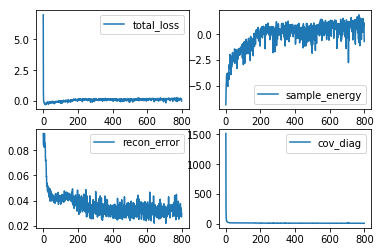

100%|██████████| 194/194 [00:06<00:00, 31.20it/s]

phi tensor([ 0.9972,  0.0012,  0.0006,  0.0009]) mu tensor([[ 0.0727,  0.3286,  0.4553],
        [-0.8911,  1.3659,  0.1561],
        [-1.0515,  1.3334,  0.1053],
        [-1.0120,  1.1189,  0.1172]]) cov tensor([[[ 7.5967, -1.3054,  2.3822],
         [-1.3054,  0.3319, -0.4100],
         [ 2.3822, -0.4100,  0.7473]],

        [[ 8.1536, -0.7324,  2.5585],
         [-0.7324,  4.5955, -0.2175],
         [ 2.5585, -0.2175,  0.8031]],

        [[ 8.3444, -0.6692,  2.6180],
         [-0.6692,  4.3315, -0.1997],
         [ 2.6180, -0.1997,  0.8216]],

        [[ 8.6645, -0.9290,  2.7178],
         [-0.9290,  3.4709, -0.2837],
         [ 2.7178, -0.2837,  0.8527]]])


In [8]:
solver = main(hyperparams(defaults))

In [ ]:
accuracy, precision, recall, f_score = solver.test()

### I copy pasted the testing code here in the notebook so we could play around the results.

### Incrementally compute for the GMM parameters across all training data for a better estimate

In [9]:
solver.data_loader.dataset.mode="train"
solver.dagmm.eval()
N = 0
mu_sum = 0
cov_sum = 0
gamma_sum = 0

for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    phi, mu, cov = solver.dagmm.compute_gmm_params(z, gamma)
    
    batch_gamma_sum = torch.sum(gamma, dim=0)
    
    gamma_sum += batch_gamma_sum
    mu_sum += mu * batch_gamma_sum.unsqueeze(-1) # keep sums of the numerator only
    cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1) # keep sums of the numerator only
    
    N += input_data.size(0)
    
train_phi = gamma_sum / N
train_mu = mu_sum / gamma_sum.unsqueeze(-1)
train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

print("N:",N)
print("phi :\n",train_phi)
print("mu :\n",train_mu)
print("cov :\n",train_cov)

N: 198371
phi :
 tensor([ 0.9986,  0.0006,  0.0003,  0.0005])
mu :
 tensor([[ 0.0688,  0.3370,  0.4543],
        [ 0.5024,  3.3925, -0.2412],
        [ 0.1810,  3.0740, -0.2851],
        [ 0.4916,  3.2641, -0.3154]])
cov :
 tensor([[[  7.6382,  -1.2606,   2.3449],
         [ -1.2606,   0.3531,  -0.4154],
         [  2.3449,  -0.4154,   0.7346]],

        [[ 10.8552,   3.0573,   0.6293],
         [  3.0573,   5.1484,   0.3815],
         [  0.6293,   0.3815,   0.4404]],

        [[ 11.7751,   3.4579,   0.8378],
         [  3.4579,   5.0717,   0.3323],
         [  0.8378,   0.3323,   0.4635]],

        [[ 11.7543,   3.4524,   0.6498],
         [  3.4524,   4.7640,   0.3856],
         [  0.6498,   0.3856,   0.4141]]])


In [10]:
train_energy = []
train_labels = []
train_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)
    
    train_energy.append(sample_energy.data.cpu().numpy())
    train_z.append(z.data.cpu().numpy())
    train_labels.append(labels.numpy())


train_energy = np.concatenate(train_energy,axis=0)
train_z = np.concatenate(train_z,axis=0)
train_labels = np.concatenate(train_labels,axis=0)

### Compute the energy of every sample in the test data

In [11]:
solver.data_loader.dataset.mode="test"
test_energy = []
test_labels = []
test_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, size_average=False)
    test_energy.append(sample_energy.data.cpu().numpy())
    test_z.append(z.data.cpu().numpy())
    test_labels.append(labels.numpy())


test_energy = np.concatenate(test_energy,axis=0)
test_z = np.concatenate(test_z,axis=0)
test_labels = np.concatenate(test_labels,axis=0)

In [12]:
combined_energy = np.concatenate([train_energy, test_energy], axis=0)
combined_z = np.concatenate([train_z, test_z], axis=0)
combined_labels = np.concatenate([train_labels, test_labels], axis=0)

### Compute for the threshold energy. Following the paper I just get the highest 20% and treat it as an anomaly. That corresponds to setting the threshold at the 80th percentile.

In [13]:
thresh = np.percentile(combined_energy, 100 - 20)
print("Threshold :", thresh)

Threshold : 1.9702191352844238


In [14]:
pred = (test_energy>thresh).astype(int)
gt = test_labels.astype(int)

In [15]:
#The prediction of anomalies 
print(pred.shape)
print(pred)

(295650,)
[0 1 0 ... 0 0 1]


In [16]:
#Labels 
print(gt.shape)
print(gt)

(295650,)
[0 0 0 ... 0 0 1]


In [17]:
# https://scikit-learn.org/0.18/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

In [18]:
accuracy = accuracy_score(gt,pred)
precision, recall, f_score, support = prf(gt, pred, average='binary')

In [19]:
print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy,precision, recall, f_score))

Accuracy : 0.7068, Precision : 0.5546, Recall : 0.5535, F-score : 0.5540


## Visualizing the z space
It's a little different from the paper's figure but I assume that's because of the small changes in my implementation.

<IPython.core.display.Javascript object>


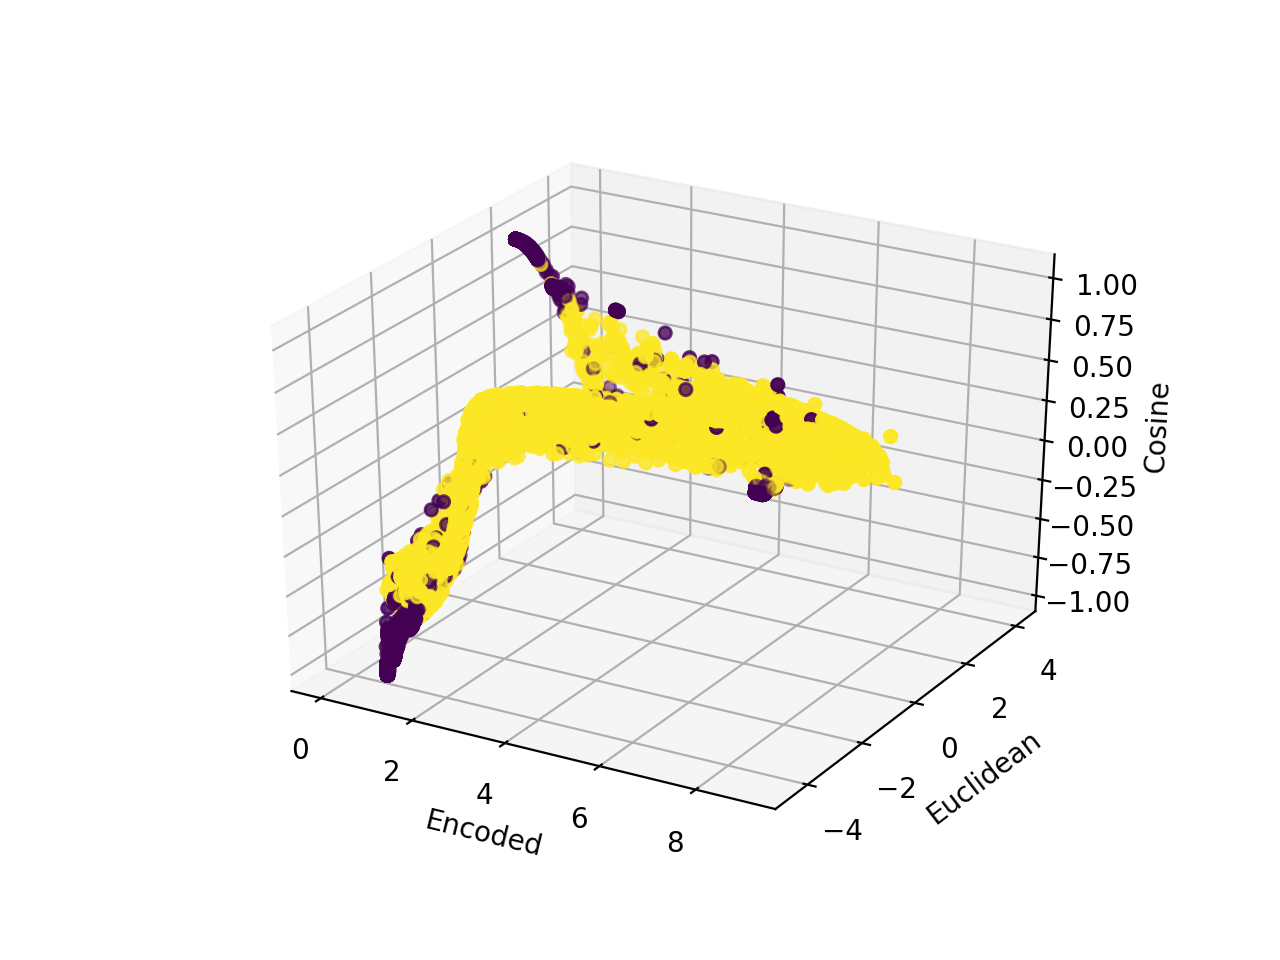

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_z[:,1],test_z[:,0], test_z[:,2], c=test_labels.astype(int))
ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')
plt.show()